## EDA and Visualisations

In [ ]:
!pip install -q geopandas
!pip install -q mapclassify

     |████████████████████████████████| 1.0MB 9.0MB/s 
     |████████████████████████████████| 6.6MB 43.9MB/s 
     |████████████████████████████████| 15.4MB 357kB/s 


In [ ]:
import geopandas
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
LOAN = "/content/drive/MyDrive/MoneyLionDataset/loan.csv"
PAYMENT = "/content/drive/MyDrive/MoneyLionDataset/payment.csv"
CLARITY = "/content/drive/MyDrive/MoneyLionDataset/clarity_underwriting_variables.csv"

In [ ]:
df_loan = pd.read_csv(LOAN, parse_dates=['applicationDate', 'originatedDate'])
df_payment = pd.read_csv(PAYMENT, parse_dates=['paymentDate'])

In [ ]:
unique_loan_status = df_loan.loanStatus.unique()
pprint(unique_loan_status)

array(['Withdrawn Application', 'Paid Off Loan', 'Rejected', 'New Loan',
       'Internal Collection', 'CSR Voided New Loan',
       'External Collection', 'Returned Item', 'Customer Voided New Loan',
       'Credit Return Void', 'Pending Paid Off', 'Charged Off Paid Off',
       nan, 'Settled Bankruptcy', 'Settlement Paid Off', 'Charged Off',
       'Pending Rescind', 'Customver Voided New Loan',
       'Pending Application', 'Voided New Loan',
       'Pending Application Fee', 'Settlement Pending Paid Off'],
      dtype=object)


In [ ]:
df_loan['loanStatus'].value_counts(normalize=True)

Withdrawn Application          0.781207
Rejected                       0.147361
Paid Off Loan                  0.019794
External Collection            0.019633
New Loan                       0.014052
Internal Collection            0.009643
Returned Item                  0.002047
CSR Voided New Loan            0.001777
Settlement Paid Off            0.001226
Credit Return Void             0.001219
Customer Voided New Loan       0.000873
Settled Bankruptcy             0.000565
Pending Paid Off               0.000293
Charged Off Paid Off           0.000277
Pending Application Fee        0.000009
Pending Application            0.000007
Pending Rescind                0.000007
Voided New Loan                0.000003
Customver Voided New Loan      0.000002
Settlement Pending Paid Off    0.000002
Charged Off                    0.000002
Name: loanStatus, dtype: float64

The model would have to predict whether or not a loan would be repayed or not by a person which is a binary classification task. For this I will need to select which loan statuses fall under the positive class or the negative class. 

Positive class(Loan repayed):

- Paid Off Loan
- Settlement Paid Off
- *Maybe External/Internal Collection could be included but I am still not sure what it means as it's not documented so I will leave it out.* 

Negative class(Loan not repayed):

- Customer Voided New Loan
- Settled Bankruptcy: Customer has a bankruptcy settlement which indicates that they are in debt and unable to pay the loans
- Charged Off: Declaration by a creditor that an amount of debt is unlikely to be collected. 

I will also need to only select the payments that are considered *Funded*. 

In [ ]:
classes = {
    1: ["Paid Off Loan", "Settlement Paid Off"],
    0: ["Customver Voided New Loan", "Settled Bankruptcy","Charged Off", "Customer Voided New Loan"] 
}

In [ ]:
def map_classes(row):
  for key, value in classes.items():
    if row in value:
      return key

In [ ]:
df_loan = df_loan[df_loan.isFunded == 1] # Filter loans that are funded 
df_loan['target'] = df_loan['loanStatus'].map(map_classes)

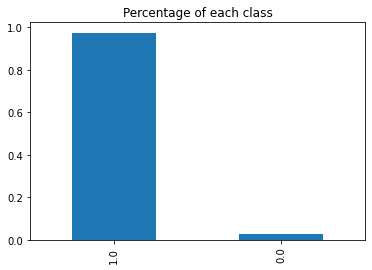

In [ ]:
df_loan['target'].value_counts(normalize=True).plot(kind='bar', x='Class', title='Percentage of each class')

In [ ]:
df_loan['target'].value_counts(normalize=True)

1.0    0.973838
0.0    0.026162
Name: target, dtype: float64

## Massive Class Imbalance 

There is a huge difference between the positive class and the negative class which makes modelling the data difficult. To help mitigate the effects of a large class imbalance I could use **SMOTE** or **EasyEnsemble** to ensure the model is not biased towards the majority class which is the positive class. Moreover, this has shown that using plain accuracy as a metric to measure the performance of the model as a model with 97% accuracy here could just predict all the positive classes correctly but get all the negative classes wrongly which causes loans to be approved to people that are going to default on it causing losses to MoneyLion. 

The performance metric/s that needs to be chosen needs to perform well enough on detecting the positive classes as well as the negative classes and reduce the risk of false positives and false negatives from happening. For this I will look at the **F1-score** as the performance metric.

Now I will do a more in depth round of EDA just on the loan data comparing the independent variables and the dependent variables to gather  more insights. But first I will need to separate the data into Numerical and Categorical Features. 

In [ ]:
df_loan.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38982 entries, 1 to 577662
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   loanId                            38982 non-null  object        
 1   anon_ssn                          38982 non-null  object        
 2   payFrequency                      38982 non-null  object        
 3   apr                               38982 non-null  float64       
 4   applicationDate                   38982 non-null  datetime64[ns]
 5   originated                        38982 non-null  bool          
 6   originatedDate                    38982 non-null  datetime64[ns]
 7   nPaidOff                          38961 non-null  float64       
 8   approved                          38982 non-null  bool          
 9   isFunded                          38982 non-null  int64         
 10  loanStatus                        38982 non-n

In [ ]:
def plot_target_vs_col(df, col, lim=2000):
  """
  Plots categorical features vs the Default and Paid Off classes of 
  the target column
  """
  total = len(df)
  tmp = pd.crosstab(df[col], df['target'], normalize='index') * 100
  tmp = tmp.reset_index()
  tmp.rename(columns={0:'Default', 1:'Paid Off'}, inplace=True)
  
  plt.figure(figsize=(16,14))    
  plt.suptitle(f'{col} Distributions ', fontsize=24)
  
  plt.subplot(211)
  g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
  gt = g.twinx()
  gt = sns.pointplot(x=col, y='Paid Off', data=tmp, order=list(tmp[col].values),
                      color='black', legend=False, )
  gt.set_ylim(0,tmp['Paid Off'].max()*1.1)
  gt.set_ylabel("% Paid Off", fontsize=16)
  g.set_title(f"Most Frequent {col} values and % Paid Off Loans", fontsize=20)
  g.set_xlabel(f"{col} Category Names", fontsize=16)
  g.set_ylabel("Count", fontsize=17)
  g.set_xticklabels(g.get_xticklabels(),rotation=45)
  sizes = []
  for p in g.patches:
      height = p.get_height()
      sizes.append(height)
      g.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}%'.format(height/total*100),
              ha="center",fontsize=12) 
      
  g.set_ylim(0,max(sizes)*1.15)

  plt.subplot(212)
  g1 = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
  g1t = g1.twinx()
  g1t = sns.pointplot(x=col, y='Default', data=tmp, order=list(tmp[col].values),
                      color='black', legend=False, )
  g1t.set_ylim(0,tmp['Default'].max()*1.1)
  g1t.set_ylabel("% Default", fontsize=16)
  g.set_xticklabels(g.get_xticklabels(),rotation=45)
  g1.set_title(f"Most Frequent {col} values and % Default Loans", fontsize=20)
  g1.set_xlabel(f"{col} Category Names", fontsize=16)
  g1.set_ylabel("Count", fontsize=17)
  g1.set_xticklabels(g.get_xticklabels(),rotation=45)
  sizes = []
  for p in g1.patches:
      height = p.get_height()
      sizes.append(height)
      g1.text(p.get_x()+p.get_width()/2.,
              height + 3,
              '{:1.2f}%'.format(height/total*100),
              ha="center",fontsize=12) 
      
  g1.set_ylim(0,max(sizes)*1.15)

  plt.subplots_adjust(hspace=.4, top = 0.9)
  plt.show()

## Plotting the Categorical Features vs Paid Off Loans & Default

Next, I will be plotting the categorical features with low cardinality to see the relationship they have with both values of the target values. 

The first plot would be the categorical feature vs the % Paid Off Loans
and the second one would be the same categorical feature vs the % Default on Loan

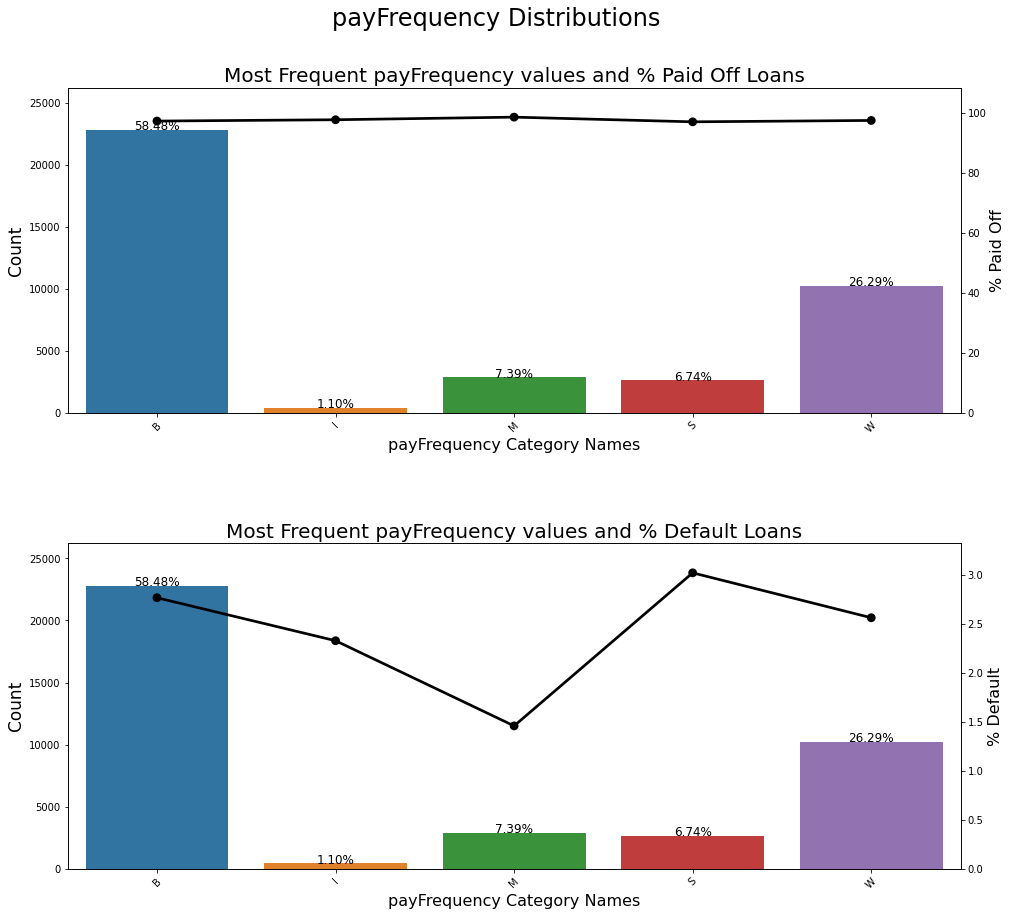

In [ ]:
plot_target_vs_col(df_loan, 'payFrequency')

There don't seem to be irregularities between **payFrequency** and **Paid Off Loans** but with **% Default Loans** payment plans that are made irregularly have a lower % of Defaults which is not what I would have thought off. My assumption is that people that make payments on an irregular basis would be more likely to Default. 

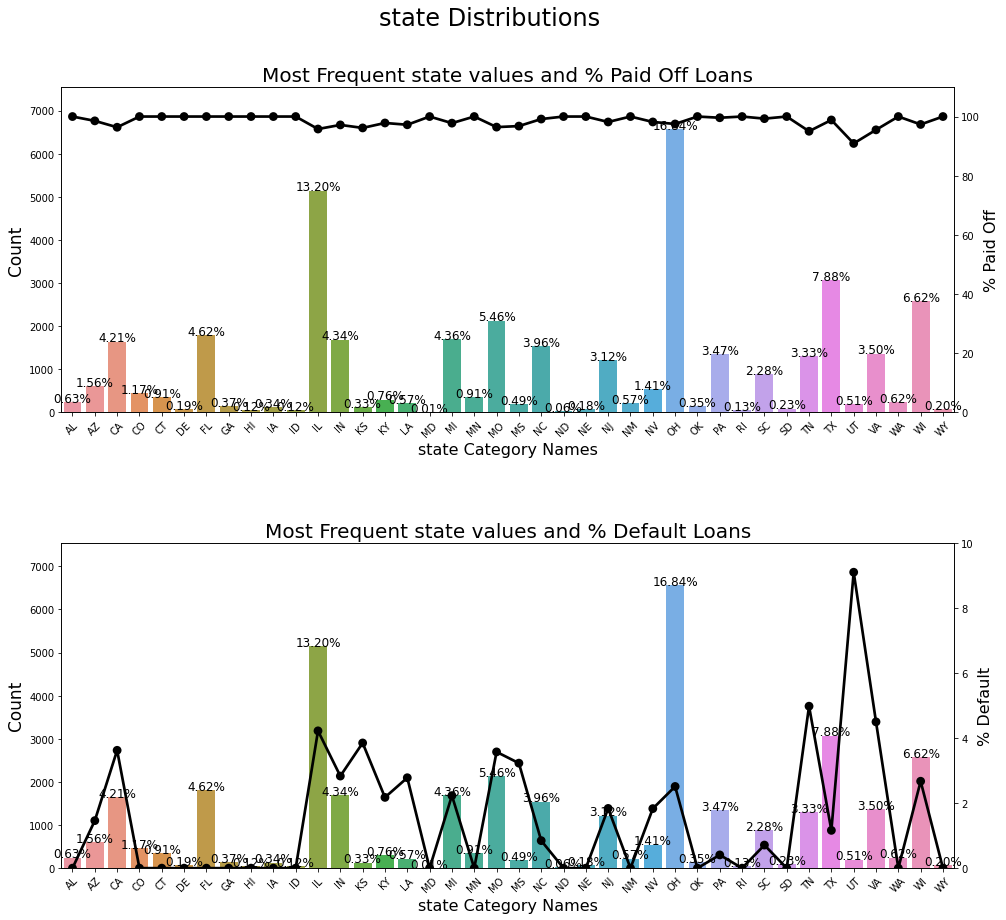

In [ ]:
plot_target_vs_col(df_loan, 'state')

UT, TN and VA have an unusualy high % of defaults compared to the rest of states in the US

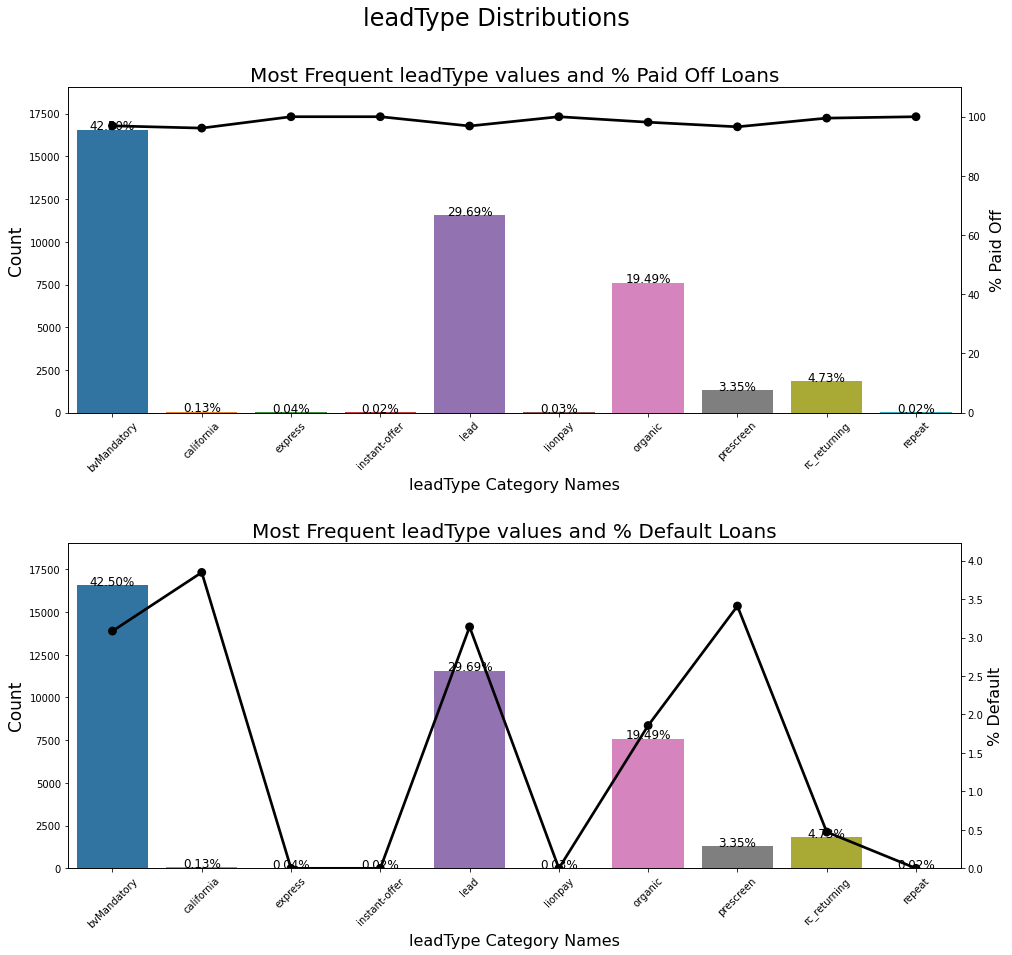

In [ ]:
plot_target_vs_col(df_loan, 'leadType')

Defaults happen at a greater % when leads are generated from **lead** which makes sense as according to the documentation this method differs from bvMandatory where bank verification is optional for *lead*. Perhaps MoneyLion should forgo this type of lead to minimize the number for defaults. 

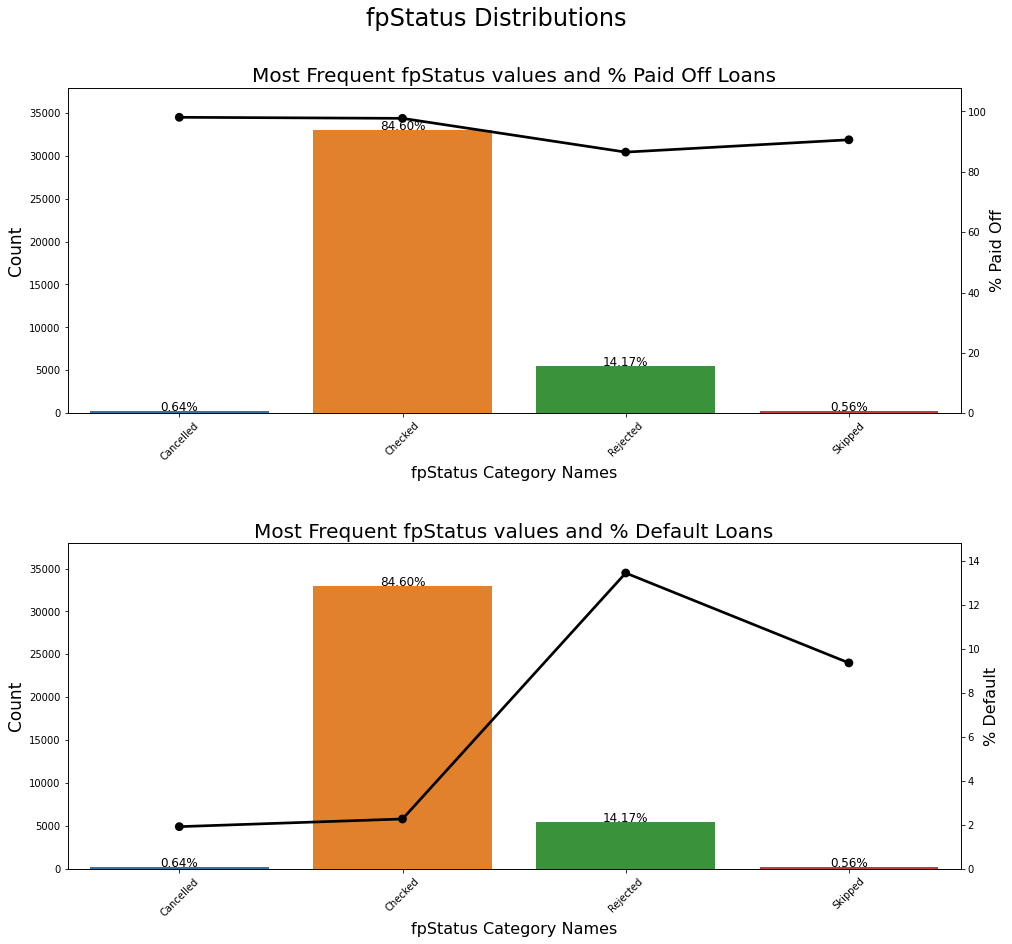

In [ ]:
plot_target_vs_col(df_loan, 'fpStatus')

I am adding in the categorical features from the payment dataset to the current loan dataset and performing the same type of plotting. 

In [ ]:
# Join the loan data with the payment data only including the columns loanId and isCollection
df_ = pd.merge(df_loan, df_payment.loc[:, ["loanId", "isCollection"]], left_on="loanId", right_on="loanId", how="left")
df_['target'] = df_['loanStatus'].map(map_classes)

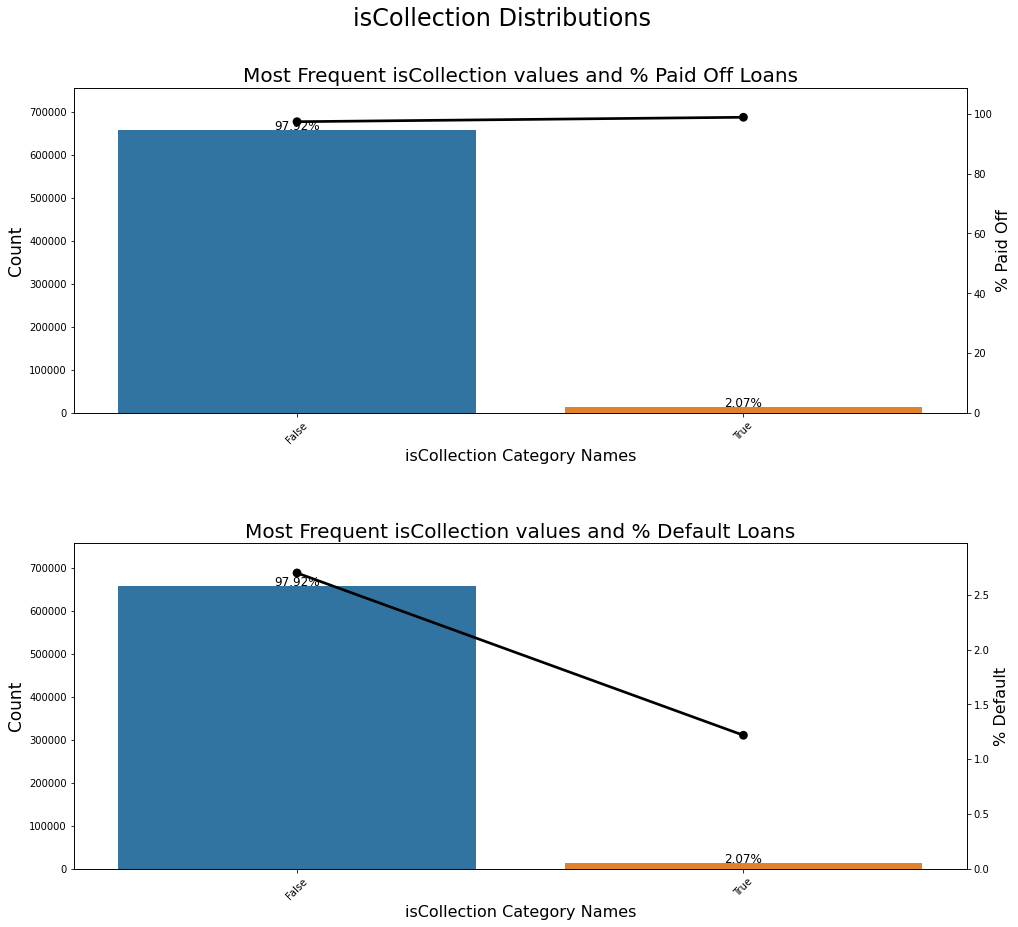

In [ ]:
plot_target_vs_col(df_, 'isCollection')

Looking at the *isCollection* variable for the default scenario it seems that offering a custom made collection plan to the customer when they have issues making payments does reduce the likeliness of them defaulting by a few %, so perhaps MoneyLion should offer this to more customers to reduce the number of defaults. 

I noticed that the data does not have information about the users
credit score which I think would be beneficial in modelling, so instead I will try to generate the credit scores based off the interest rate that the user gets for a loan. Customers are given interest rates according to their credit score and therefore can be grouped according to different credit groups. 

In [ ]:
df_payment_amount= df_payment.groupby(["loanId"]).paymentAmount.agg(total_amount_paid = 'sum').reset_index()

In [ ]:
df_ = pd.merge(df_, df_payment_amount, left_on="loanId", right_on="loanId", how="left").drop_duplicates('loanId').reset_index()

In [ ]:
df_['remainder_to_pay'] = df_['originallyScheduledPaymentAmount'] - df_['total_amount_paid']

In [ ]:
# Round the float columns 
df_ = df_.round(4)

In [ ]:
df_.sample(10)

,index,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,isCollection,total_amount_paid,remainder_to_pay
7818,135359,LL-I-17734384,d085f108f90abb80765e7a3c13173bdc,B,555.00,2017-02-27 16:46:50.178,True,2017-02-27 17:49:53.387,5.0,True,1,New Loan,300.0,858.57,FL,rc_returning,0,Checked,NaN,0,NaN,False,858.57,0.00
20536,355115,LL-I-14009427,daad0b670fc3652f1f27e0da05ec1ff7,W,645.00,2016-12-27 19:58:23.235,True,2016-12-28 20:50:26.223,0.0,True,1,New Loan,600.0,2027.11,CA,organic,0,Checked,5862c7dbe4b08f246b690914,1,NaN,False,2027.11,-0.00
36805,634474,LL-I-06942189,407745e24265d10c13ff384344848c43,B,390.00,2016-02-01 14:22:58.144,True,2016-02-29 20:28:19.242,1.0,True,1,External Collection,1000.0,2127.74,MO,lead,75,Checked,563bb7dce4b07887b43713f9,1,NaN,False,2305.05,-177.31
22306,385260,LL-I-15522892,80560d40d0a1daddc0ce0c50c8eb46e5,B,645.00,2017-01-17 04:42:58.096,True,2017-01-20 21:15:01.201,0.0,True,1,Paid Off Loan,350.0,1142.47,AL,lead,25,Checked,587da0cfe4b08f248a82d7c9,1,1.0,False,1495.11,-352.64
6227,107954,LL-I-09512608,83b675babaec519dc2e4c3bfef63000a,B,324.00,2016-06-03 23:59:03.609,True,2016-06-04 16:07:00.244,1.0,True,1,Paid Off Loan,1350.0,2876.37,IL,organic,0,Checked,565c6849e4b0819f3a32cc22,1,1.0,False,5240.09,-2363.72
27898,481755,LL-I-05082592,62bc5f79016e3bddbfa02d90764ea36f,I,360.00,2015-11-28 17:29:57.267,True,2015-11-29 02:43:02.096,0.0,True,1,Paid Off Loan,800.0,1737.94,IL,lead,100,Checked,5659e482e4b0819f38a2c397,1,1.0,False,1737.94,0.00
4876,84539,LL-I-17767683,8537ed53f1c7f26688bfc09ebccb93a0,B,180.20,2017-02-28 03:31:47.187,True,2017-02-28 03:45:06.527,0.0,True,1,New Loan,500.0,745.23,CO,lead,40,Checked,58b4ef20e4b0d99c3e7fb92a,1,NaN,False,745.23,0.00
33409,576970,LL-I-12765496,f6ff306f705cf0e4966cf37b47dec0bd,W,645.00,2016-12-09 13:12:36.717,True,2016-12-09 15:29:33.189,0.0,True,1,Internal Collection,1250.0,4307.65,PA,lead,6,Checked,584aadbde4b0286c4f56be14,1,NaN,False,4307.65,0.00
17843,308184,LL-I-16820215,5f58e243b982321178cbda3f24bea20c,S,590.00,2017-02-07 11:56:03.895,True,2017-02-07 19:00:08.694,0.0,True,1,New Loan,600.0,1819.15,OH,lead,25,Checked,5899b5d1e4b0040df858453a,1,NaN,False,1813.15,6.00
38396,661810,LL-I-04261659,64383992cdc315765e45204430c77404,B,449.99,2015-11-02 20:49:54.973,True,2015-11-02 21:04:06.139,0.0,True,1,Paid Off Loan,400.0,827.11,WI,bvMandatory,6,Checked,NaN,0,1.0,False,1256.63,-429.52


In [ ]:
# Filter to check all target columns have a value of 0 or 1
df_loan_paid = df_[~df_.target.isna()]

In [ ]:
losses_loan = df_loan_paid.remainder_to_pay.sum()
supposed_revenue = df_loan_paid.originallyScheduledPaymentAmount.sum()
total_amount_paid = df_loan_paid.total_amount_paid.sum()
print(f"Total amount overpaid by customers: {-losses_loan}\nExpected revenue: {supposed_revenue}\nTotal amount customers actually paid: {total_amount_paid}")

Total amount overpaid by customers: 4390912.2
Expected revenue: 20706296.78
Total amount customers actually paid: 25094735.89


According to the documentation *originallyScheduledPaymentAmount* is the amount MoneyLion should receive if all the loans are paid off. 

So subtracting the *amount paid* by the customer and *originallyScheduledPaymentAmount* should give me the amount that is owed by the customer. 

It is a bit odd that customers paid more than they were supposed to by a factor of 20%, so maybe there is something I am missing here about  *originallyScheduledPaymentAmount*. 

I do not think I can gather the interest rates here as I initially assumed that *loanAmount* was loan the customer took but it is actually the Principal of Loan which shows how much the customer has left to pay. 

## Visualising the data on a map

Now I will visualise some important metrics based on state data such as:

1. Total Loan Amount by State
2. Total Amount Paid Per State
3. Total Remainder To Pay Per State
4. Mean APR Per State
5. Total Loans Paid Per State
6. Total Loans Defaulted Per State

In [ ]:
# Shapefile from https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
SHAPE_FILE = "/content/drive/MyDrive/MoneyLionDataset/cb_2018_us_state_20m/cb_2018_us_state_20m.shp"
# USA information from https://github.com/melanieshi0120/COVID-19_global_time_series_panel_data/blob/master/data/usa_State_locaiton.csv
USA_DATA = "/content/drive/MyDrive/MoneyLionDataset/USA_STATE_LOCATION.csv"

In [ ]:
df_usa = pd.read_csv(USA_DATA)
df_usa.head(5)

,name,state,latitude,longitude
0,Alabama,AL,32.318230,-86.902298
1,Alaska,AK,66.160507,-153.369141
2,Arizona,AZ,34.048927,-111.093735
3,Arkansas,AR,34.799999,-92.199997
4,California,CA,36.778259,-119.417931


In [ ]:
# Add the information such as latitude, longitude to the df
df_map = pd.merge(df_loan_paid, df_usa, left_on="state", right_on="state", how="outer")

In [ ]:
df_map.sample(10)

,index,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,isCollection,total_amount_paid,remainder_to_pay,name,latitude,longitude
11067,488906.0,LL-I-12409591,0e77bbe4d1a27e8acc883b4f9b5d089b,B,590.00,2016-12-02 17:27:20.058,True,2016-12-02 18:00:11.180,0.0,True,1.0,Paid Off Loan,500.0,1519.96,WY,bvMandatory,6.0,Checked,5841b0c8e4b0bb9d6a60ddbd,1.0,1.0,False,2019.96,-500.00,Wyoming,43.075970,-107.290283
7468,491363.0,LL-I-11369519,499f4bd6003c4c9886aba50ca78d302c,B,360.00,2016-08-22 22:32:38.574,True,2016-08-23 16:27:25.345,0.0,True,1.0,Settled Bankruptcy,1000.0,2205.58,IL,bvMandatory,6.0,Checked,57bb3938e4b033e6e41201da,1.0,0.0,False,2375.23,-169.65,Illinois,40.000000,-89.000000
1643,281804.0,LL-I-08443657,052d616d30b3076af1f80e8a7f81efb2,B,449.99,2016-04-05 22:24:20.799,True,2016-04-06 16:05:24.869,0.0,True,1.0,Paid Off Loan,600.0,939.32,WI,bvMandatory,6.0,Checked,57043c57e4b0f1e5d772f554,1.0,1.0,False,966.36,-27.04,Wisconsin,44.500000,-89.500000
3092,140123.0,LL-I-01367467,ca88a1b9f060089092b6a67c6406038c,M,590.00,2015-05-28 23:55:03.119,True,2015-05-29 21:28:58.696,0.0,True,1.0,Paid Off Loan,300.0,926.77,OH,organic,6.0,Checked,NaN,0.0,1.0,False,1104.08,-177.31,Ohio,40.367474,-82.996216
12172,173128.0,LL-I-17108524,57b00ab91eb5a967b61a278912005469,B,590.00,2017-02-13 21:23:07.454,True,2017-02-13 21:41:50.916,3.0,True,1.0,Paid Off Loan,500.0,1623.74,MN,rc_returning,0.0,Checked,NaN,0.0,1.0,False,2104.85,-481.11,Minnesota,46.392410,-94.636230
2714,26106.0,LL-I-00433619,c2fab1f5e28cb9d952601f2ac3f03c4a,W,475.00,2015-03-22 02:31:58.903,True,2015-03-23 17:37:25.274,0.0,True,1.0,Paid Off Loan,300.0,761.55,OH,bvMandatory,3.0,Checked,NaN,0.0,1.0,False,823.54,-61.99,Ohio,40.367474,-82.996216
9931,53703.0,LL-I-05097370,f7e427d532a3246c3135af72ae310005,B,681.00,2015-11-29 03:37:25.012,True,2015-11-29 16:36:42.103,0.0,True,1.0,Settlement Paid Off,200.0,636.76,MI,bvMandatory,3.0,Checked,565a73e2e4b0819f390d7916,1.0,1.0,False,636.77,-0.01,Michigan,44.182205,-84.506836
3333,205615.0,LL-I-07094798,2bcf66d5252b880d250c8eb7c130bc7a,W,590.00,2016-02-07 04:04:49.248,True,2016-02-07 06:06:43.206,0.0,True,1.0,Paid Off Loan,300.0,896.87,OH,bvMandatory,6.0,Checked,56b6c63ce4b0044c3047c63e,1.0,1.0,False,896.87,-0.00,Ohio,40.367474,-82.996216
8184,105216.0,LL-I-11847652,13825798772247a9398ba86e46ef5f30,S,680.00,2016-09-07 20:12:42.842,True,2016-09-08 00:05:12.213,1.0,True,1.0,Paid Off Loan,500.0,1544.67,TX,organic,0.0,Checked,NaN,0.0,1.0,False,2470.04,-925.37,Texas,31.000000,-100.000000
9149,627236.0,LL-I-04646898,9f36e5ad5b1f39165a1ab1c8d19dce87,W,531.00,2015-11-15 13:25:15.730,True,2015-11-15 21:34:05.396,0.0,True,1.0,Paid Off Loan,900.0,2713.68,TN,lead,40.0,Checked,564887b6e4b033d9d46f0286,1.0,1.0,False,2909.46,-195.78,Tennessee,35.860119,-86.660156


In [ ]:
df_map.rename(columns={"name": "NAME"}, inplace=True)

In [ ]:
# Get the total loanAmount by state
loan_amount_state = df_map.groupby('NAME')['loanAmount'].sum().to_frame()
# Get the total amount paid per state
amount_paid_state = df_map.groupby('NAME')['total_amount_paid'].sum().to_frame()
# Get the remainder to pay per state
remainder_to_pay_state = df_map.groupby('NAME')['remainder_to_pay'].sum().to_frame()
# Get the average APR per state
average_apr_state = df_map.groupby('NAME')['apr'].mean().to_frame()
# Total Loans Paid Off per state
loan_paid_off_state = df_map[df_map.target == 1.0].groupby(['NAME'])['target'].count().reset_index(name='loan_paid_off')
# Total Loans Defaulted per state
loan_defaulted_state = df_map[df_map.target == 0.0].groupby(['NAME'])['target'].count().reset_index(name='loan_defaulted')

In [ ]:
# Merge all the information together

geo_usa = geopandas.read_file(SHAPE_FILE)
geo_merge = geo_usa.merge(loan_amount_state, on="NAME")
geo_merge = pd.merge(geo_merge, df_usa, left_on="NAME", right_on="name", how="outer")
geo_merge = pd.merge(geo_merge, amount_paid_state, left_on="NAME", right_on="NAME", how="outer")
geo_merge = pd.merge(geo_merge, remainder_to_pay_state, left_on="NAME", right_on="NAME", how="outer")
geo_merge = pd.merge(geo_merge, average_apr_state, left_on="NAME", right_on="NAME", how="outer")
geo_merge = pd.merge(geo_merge, loan_paid_off_state, left_on="NAME", right_on="NAME", how="outer")
geo_merge = pd.merge(geo_merge, loan_defaulted_state, left_on="NAME", right_on="NAME", how="outer")

In [ ]:
geo_merge.head(10)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,loanAmount,name,state,latitude,longitude,total_amount_paid,remainder_to_pay,apr,loan_paid_off,loan_defaulted
0,24,01714934,0400000US24,24,MD,Maryland,00,2.515110e+10,6.979967e+09,"MULTIPOLYGON (((-76.04621 38.02553, -76.00734 ...",1154.0,Maryland,MD,39.045753,-76.641273,1244.18,0.00,29.990000,2.0,NaN
1,19,01779785,0400000US19,19,IA,Iowa,00,1.446613e+11,1.084181e+09,"POLYGON ((-96.62187 42.77925, -96.57794 42.827...",15500.0,Iowa,IA,42.032974,-93.581543,57504.27,-10596.64,586.428571,21.0,NaN
2,10,01779781,0400000US10,10,DE,Delaware,00,5.045926e+09,1.399986e+09,"POLYGON ((-75.77379 39.72220, -75.75323 39.757...",5650.0,Delaware,DE,39.000000,-75.500000,23859.93,-5548.85,630.000000,11.0,NaN
3,39,01085497,0400000US39,39,OH,Ohio,00,1.058289e+11,1.026885e+10,"MULTIPOLYGON (((-82.86334 41.69369, -82.82572 ...",1292493.0,Ohio,OH,40.367474,-82.996216,4436271.77,-727062.23,569.214969,2331.0,60.0
4,42,01779798,0400000US42,42,PA,Pennsylvania,00,1.158844e+11,3.394590e+09,"POLYGON ((-80.51989 40.90666, -80.51964 40.987...",162674.0,Pennsylvania,PA,41.203323,-77.194527,640385.82,-147896.58,588.963415,245.0,1.0
5,31,01779792,0400000US31,31,NE,Nebraska,00,1.989567e+11,1.371829e+09,"POLYGON ((-104.05314 41.11446, -104.05245 41.2...",10400.0,Nebraska,NE,41.500000,-100.000000,43065.97,-10444.16,613.235294,17.0,NaN
6,01,01779775,0400000US01,01,AL,Alabama,00,1.311740e+11,4.593327e+09,"POLYGON ((-88.46866 31.89386, -88.46866 31.933...",20425.0,Alabama,AL,32.318230,-86.902298,84319.51,-18017.58,629.078947,38.0,NaN
7,05,00068085,0400000US05,05,AR,Arkansas,00,1.347689e+11,2.962860e+09,"POLYGON ((-94.61792 36.49941, -94.36120 36.499...",0.0,Arkansas,AR,34.799999,-92.199997,0.00,0.00,NaN,NaN,NaN
8,35,00897535,0400000US35,35,NM,New Mexico,00,3.141963e+11,7.287765e+08,"POLYGON ((-109.04919 31.79655, -109.04830 32.0...",19650.0,New Mexico,NM,34.307144,-106.018066,76187.78,-14939.19,615.555556,36.0,NaN
9,48,01779801,0400000US48,48,TX,Texas,00,6.766532e+11,1.900631e+10,"POLYGON ((-106.62345 31.91403, -106.63011 31.9...",354774.0,Texas,TX,31.000000,-100.000000,1187495.54,-199568.26,532.224949,681.0,8.0


In [ ]:
# Fill in all the NaN values with 0
added_cols = ['loanAmount', 'total_amount_paid', 'remainder_to_pay', 'apr', 'loan_paid_off', 'loan_defaulted']
geo_merge[added_cols] = geo_merge[added_cols].fillna(value=0)

In [ ]:
# Round the added in columns
geo_merge[added_cols] = geo_merge[added_cols].round(4)

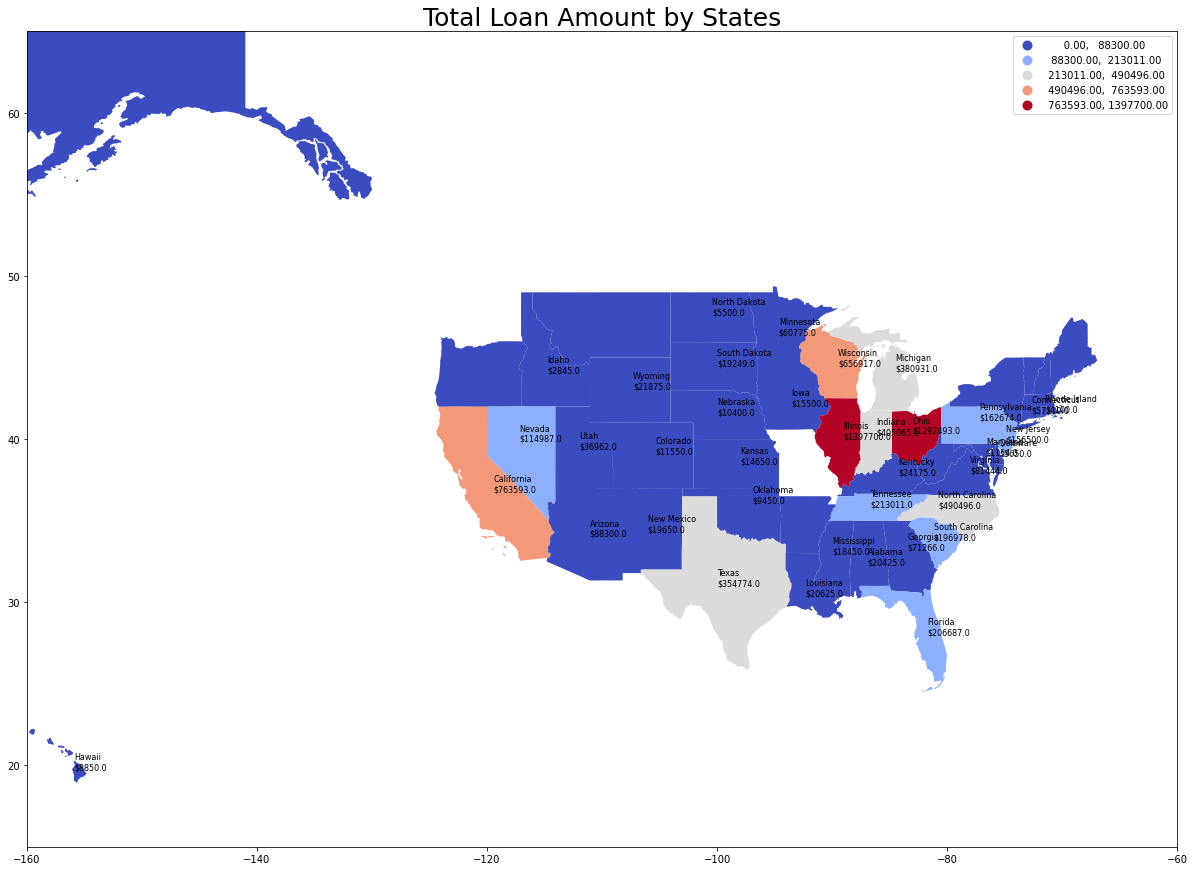

In [ ]:
geo_merge.plot(column='loanAmount',scheme="fisher_jenks", figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-160,-60)
plt.ylim(15,65)
for i in range(len(geo_merge)):
  if geo_merge.loanAmount[i] != 0:
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n${}".format(geo_merge.NAME[i],geo_merge.loanAmount[i]),size=8)
plt.title('Total Loan Amount by States',fontsize=25)
plt.show()

In the above plot we can see the top 3 states that have the highest amount of loans are Illinois, Ohio and California. 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


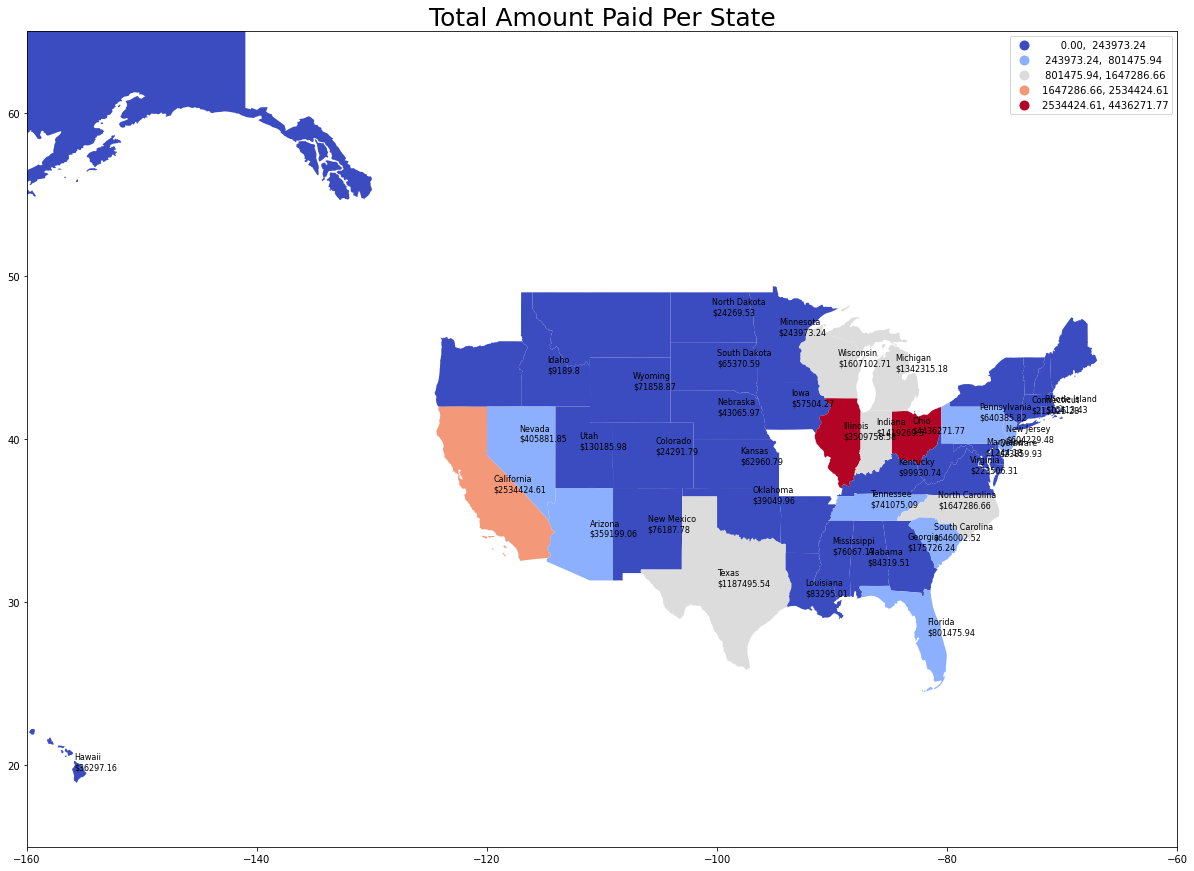

In [ ]:
geo_merge.plot(column='total_amount_paid',scheme="fisher_jenks", figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-160,-60)
plt.ylim(15,65)
for i in range(len(geo_merge)):
  if geo_merge.total_amount_paid[i] != 0:
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n${}".format(geo_merge.NAME[i],geo_merge.total_amount_paid[i]),size=8)
plt.title('Total Amount Paid Per State',fontsize=25)
plt.show()

The top 3 states that have the highest amount of paid are Illinois, Ohio and California as well. 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


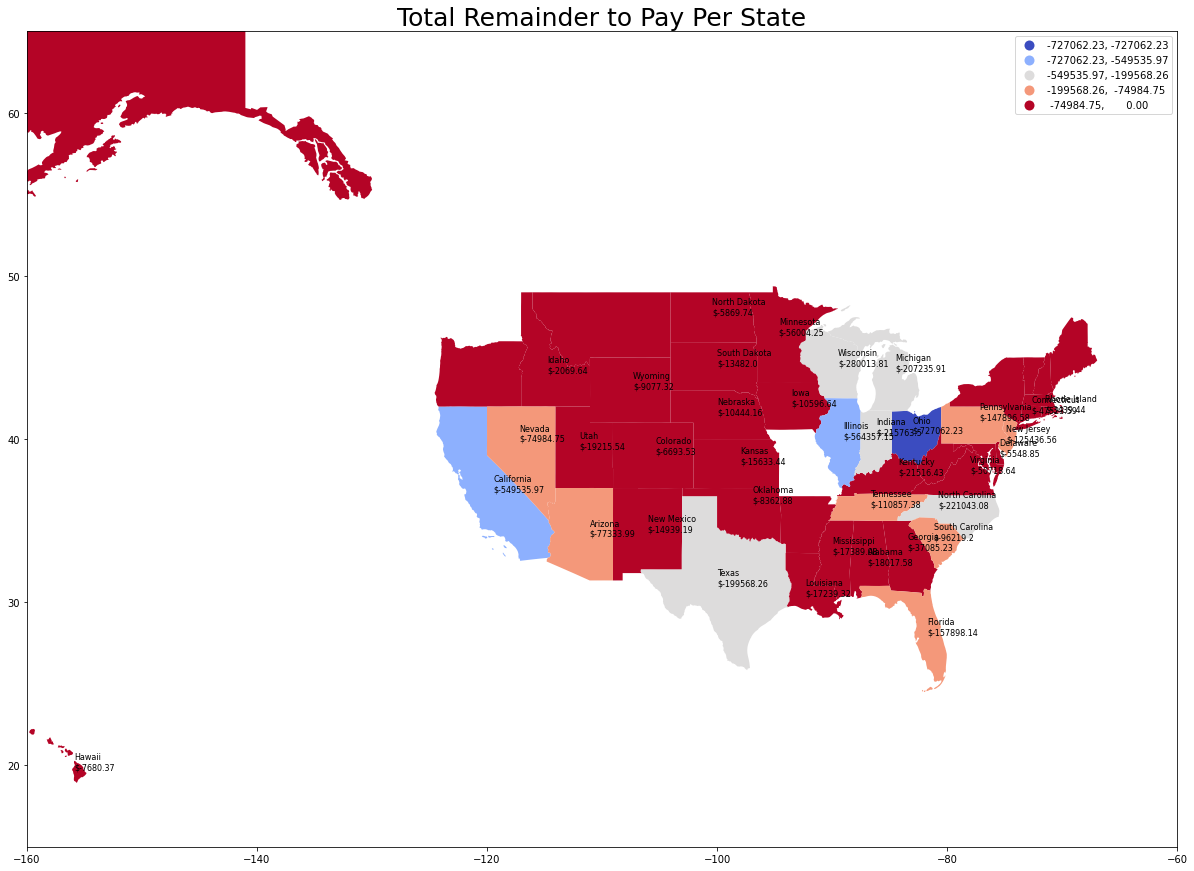

In [ ]:
geo_merge.plot(column='remainder_to_pay',scheme="fisher_jenks", figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-160,-60)
plt.ylim(15,65)
for i in range(len(geo_merge)):
  if geo_merge.remainder_to_pay[i] != 0:
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n${}".format(geo_merge.NAME[i],geo_merge.remainder_to_pay[i]),size=8)
plt.title('Total Remainder to Pay Per State',fontsize=25)
plt.show()

The plot for the remainder that each state needs to pay shows the same trend in that Illinois, Ohio and California have paid the most over the actual amount of their loan. 

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


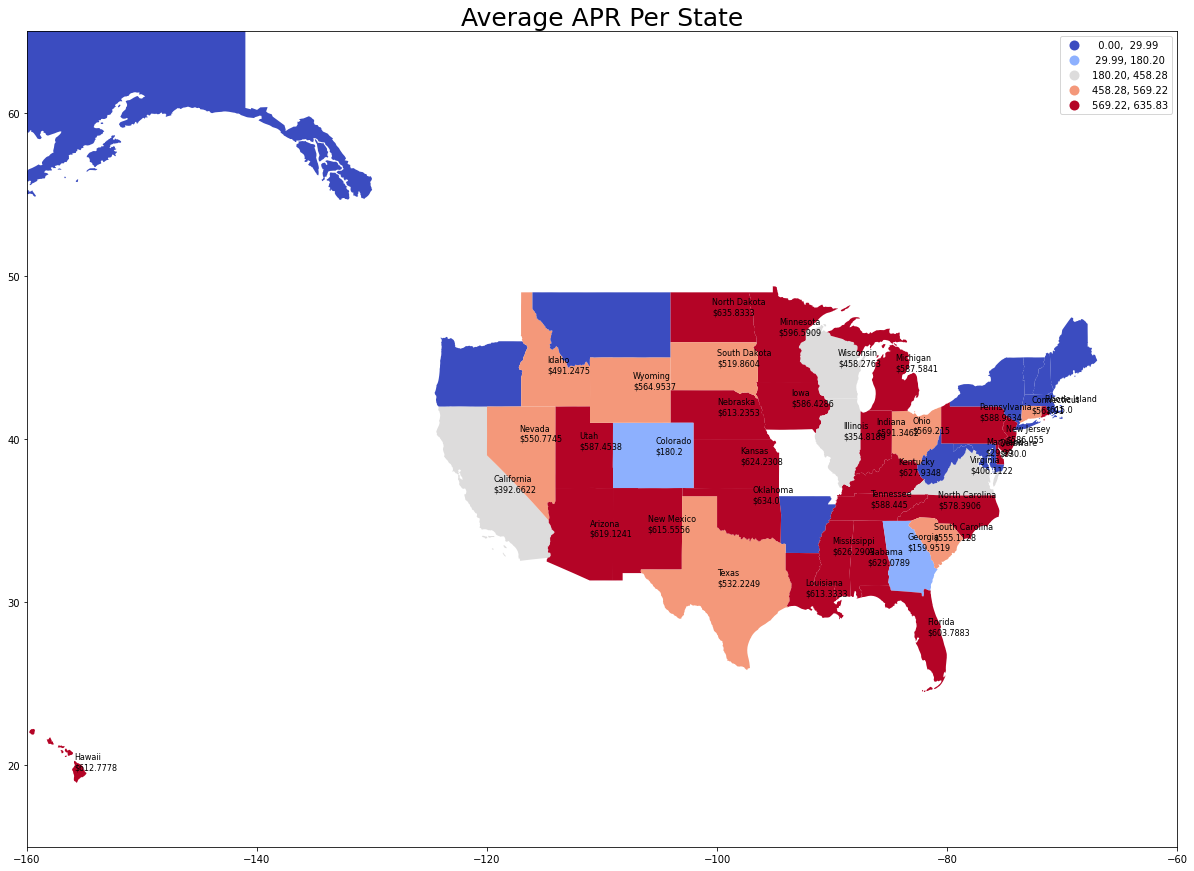

In [ ]:
geo_merge.plot(column='apr',scheme="fisher_jenks", figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-160,-60)
plt.ylim(15,65)
for i in range(len(geo_merge)):
  if geo_merge.apr[i] != 0:
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n${}".format(geo_merge.NAME[i],geo_merge.apr[i]),size=8)
plt.title('Average APR Per State',fontsize=25)
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


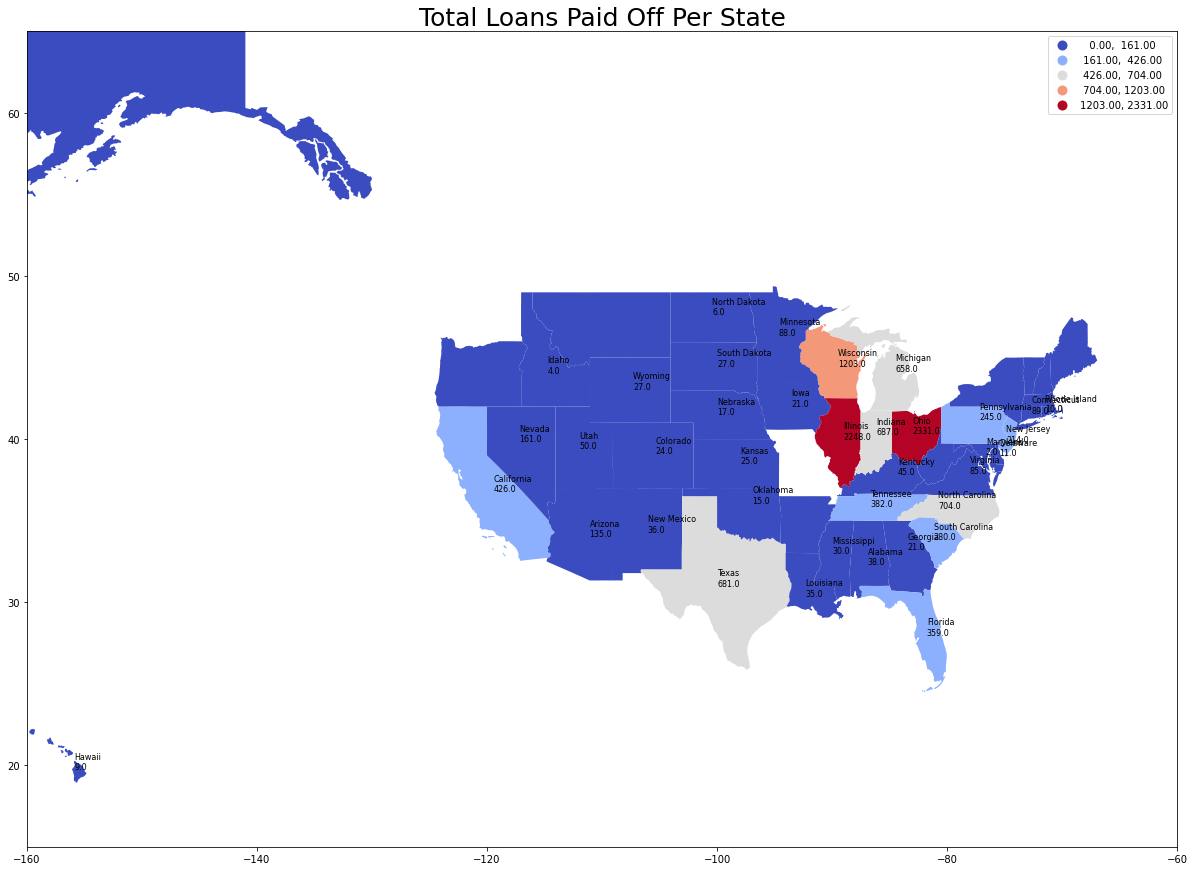

In [ ]:
geo_merge.plot(column='loan_paid_off',scheme="fisher_jenks", figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-160,-60)
plt.ylim(15,65)
for i in range(len(geo_merge)):
  if geo_merge.loan_paid_off[i] != 0:
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n{}".format(geo_merge.NAME[i],geo_merge.loan_paid_off[i]),size=8)
plt.title('Total Loans Paid Off Per State',fontsize=25)
plt.show()

Wisconsinm Illinois and Ohio are the top 3 states when it comes total loans paid back

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


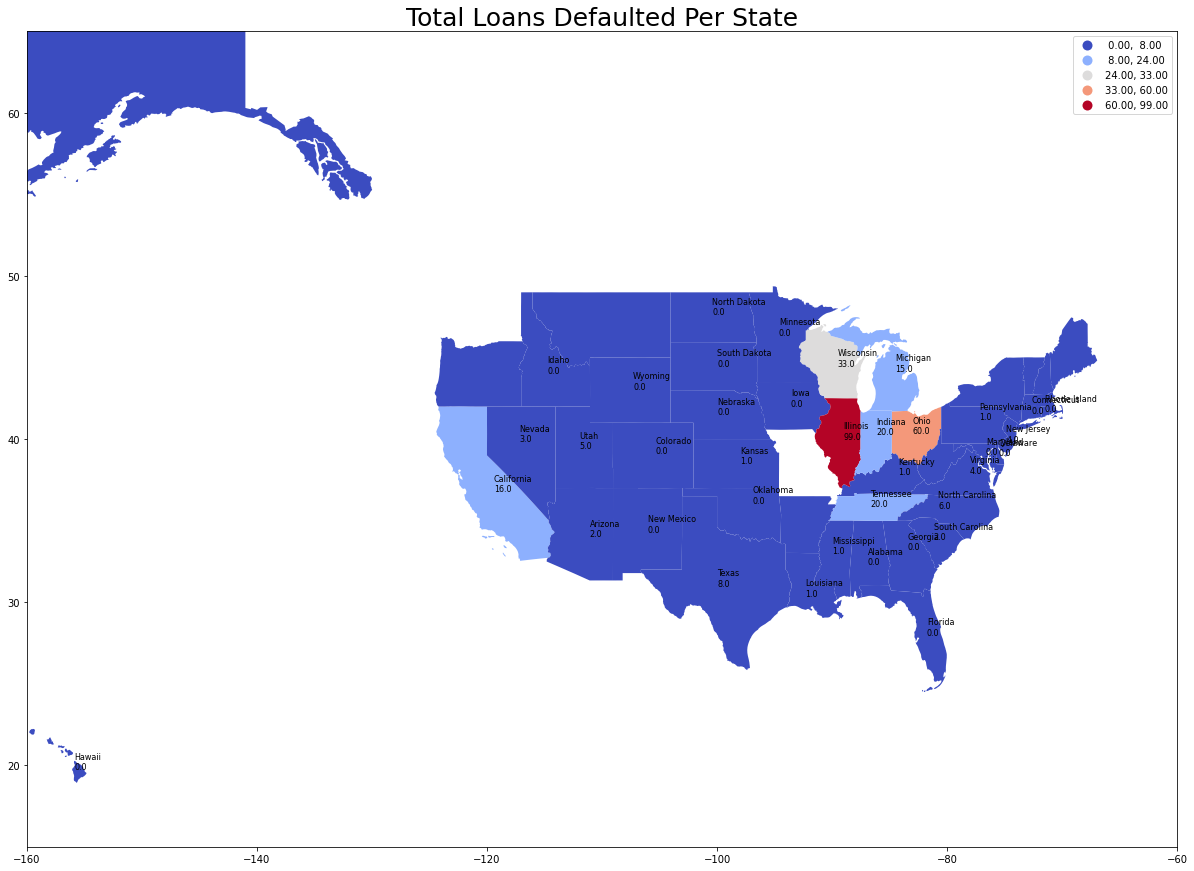

In [ ]:
geo_merge.plot(column='loan_defaulted',scheme="fisher_jenks", figsize=(25, 15),legend=True,cmap='coolwarm')
plt.xlim(-160,-60)
plt.ylim(15,65)
for i in range(len(geo_merge)):
  if geo_merge.loan_paid_off[i] != 0:
    plt.text(geo_merge.longitude[i],geo_merge.latitude[i],"{}\n{}".format(geo_merge.NAME[i],geo_merge.loan_defaulted[i]),size=8)
plt.title('Total Loans Defaulted Per State',fontsize=25)
plt.show()

With just 3% of the total data being categorised as *Defaulted* there are not enough values to plot the number of defaults per state.

In [ ]:
def get_features(df):
  """
  Takes as input the dataframe and then returns 
  the categorical, numerical and temporal variables 
  in the dataframe
  in the form of a list
  """
  cat_feat = [num for num in df.columns if df[num].dtypes == "O" or df[num].dtypes == "bool"]
  numeric_feat = [num for num in df.columns if df[num].dtypes != "O"]
  temp_variables = [num for num in df.columns if df[num].dtype == "datetime64[ns]"]
  return cat_feat, numeric_feat, temp_variables

In [ ]:
# Get the number of days the process of getting the loan took
df_loan_paid["days_to_process_loan"] = (df_loan_paid["originatedDate"] - df_loan_paid["applicationDate"]).dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


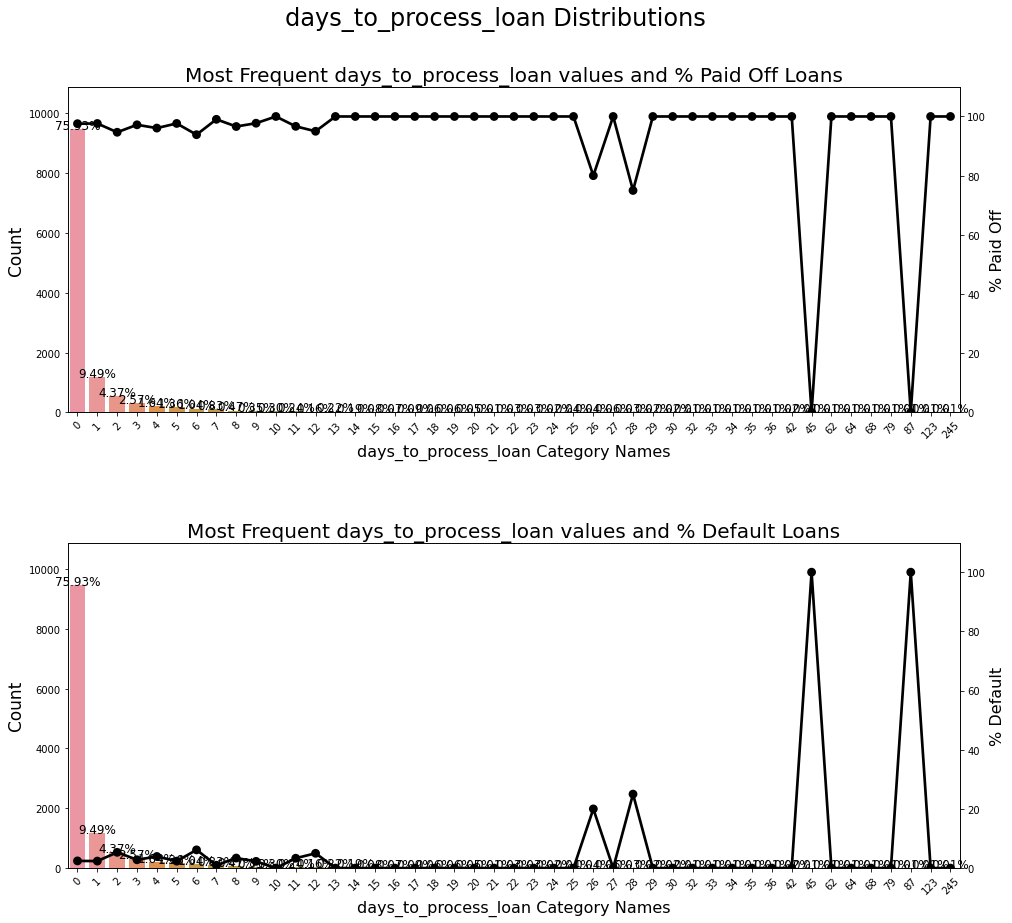

In [ ]:
plot_target_vs_col(df_loan_paid, 'days_to_process_loan')

There isn't a pattern to when loans are defaulted by the looks of the graph as there are spikes in the % of defaults after 25 day range but the number of defaults are so small for those days. I initially assumed that loans given on the same day would have resulted in customers which might default on their loan increasing but that is not the case. 

## Plotting the Distribution of Continuous Features 

In [ ]:
_, numerical_features, temporal_features = get_features(df_loan_paid)
continous_variables = [feat for feat in numerical_features if feat not in temporal_features + ["index", "target", "originated", "approved", "isFunded", "hasCF"]]
pprint(continous_variables)

['apr',
 'nPaidOff',
 'loanAmount',
 'originallyScheduledPaymentAmount',
 'leadCost',
 'total_amount_paid',
 'remainder_to_pay',
 'days_to_process_loan']


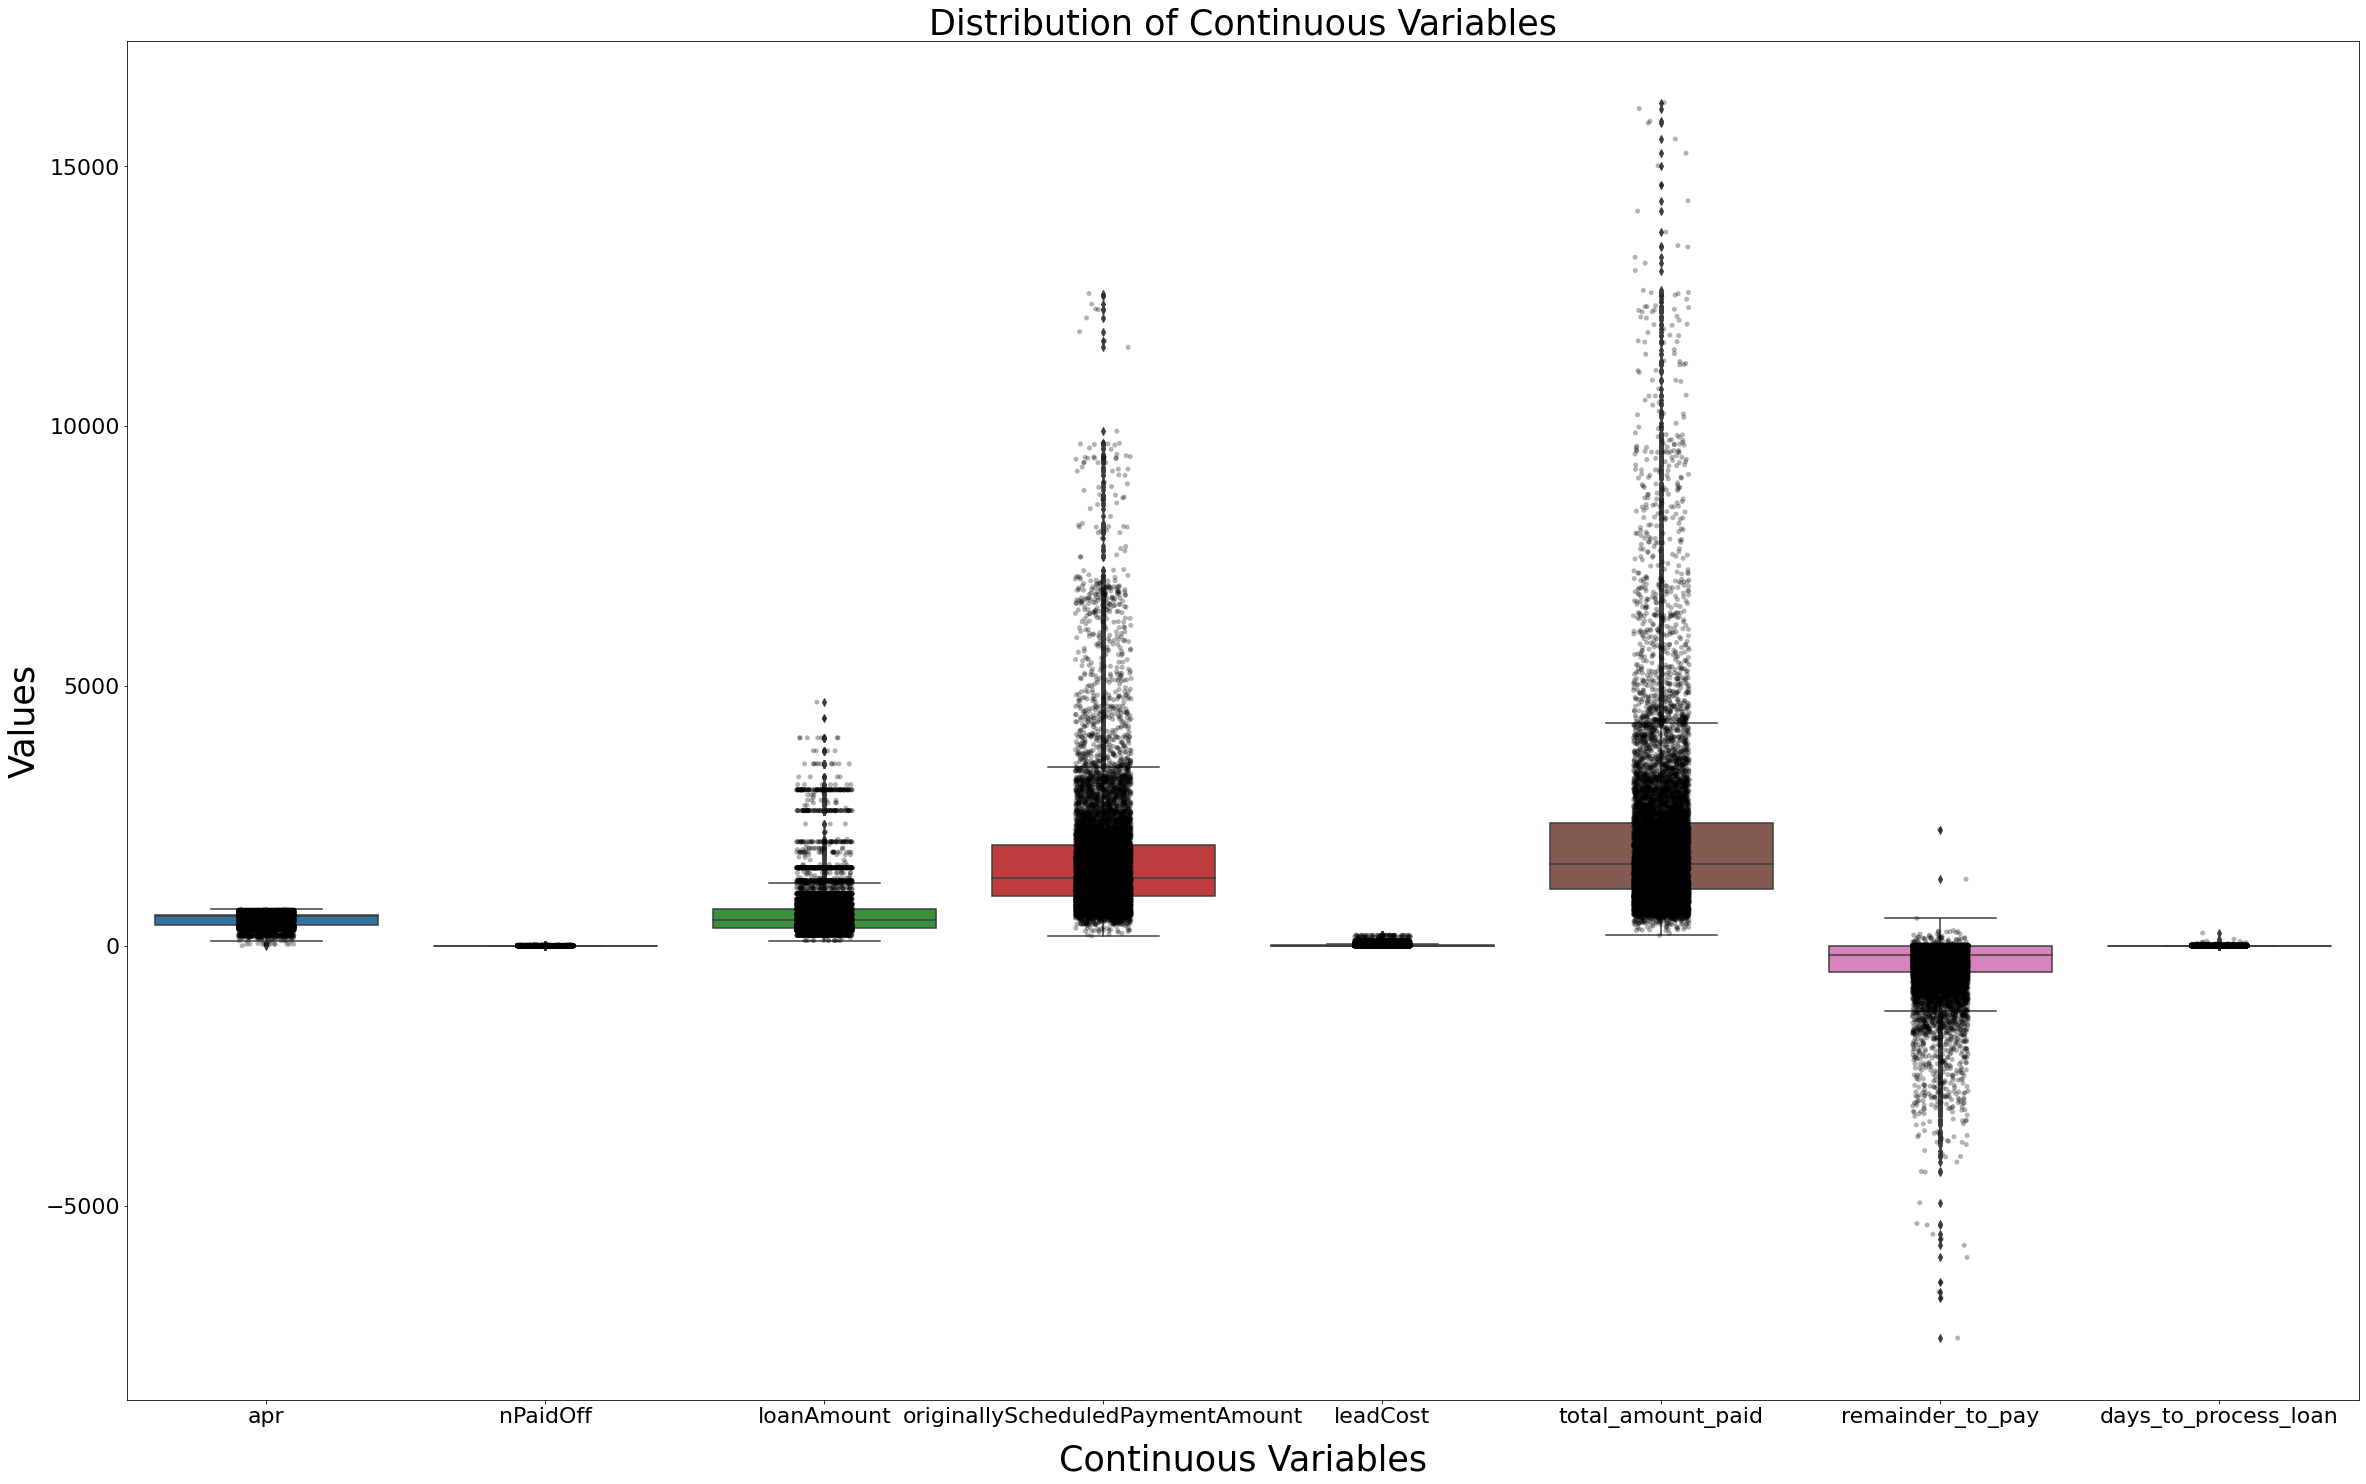

In [ ]:
plt.figure(figsize=(40,25))    
boxplot = sns.boxplot(data=df_loan_paid[continous_variables], linewidth=1.5)
boxplot = sns.stripplot(data=df_loan_paid[continous_variables], marker="o", alpha=0.3, color="black")
boxplot.axes.set_title("Distribution of Continuous Variables", fontsize=35)
boxplot.set_xlabel("Continuous Variables", fontsize=35, labelpad=15)
boxplot.set_ylabel("Values", fontsize=35)
boxplot.tick_params(axis='both', labelsize=22)
plt.show()

Most of the continuous variables plotted here are skewed which means that I will need to normalize it to form a Normal Distribution. Depending on the modelling technique I would not need to normalize the data as some are more robust to outliers such as Decision Trees or if I were using gradient descent to fit a Neural Network then normalizing these values will help convergence to a minima. 

In [ ]:
df_clarity = pd.read_csv(CLARITY)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,31,32,33,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = pd.merge(df_loan_paid, df_clarity, left_on="clarityFraudId", right_on="underwritingid", how="left")

In [ ]:
df.head(10)

,index,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,isCollection,total_amount_paid,remainder_to_pay,days_to_process_loan,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription,.underwriting

In [ ]:
# Fill clearfraudscore with the mean value 
df['clearfraudscore'] = df['clearfraudscore'].fillna(value=df['clearfraudscore'].mean())

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


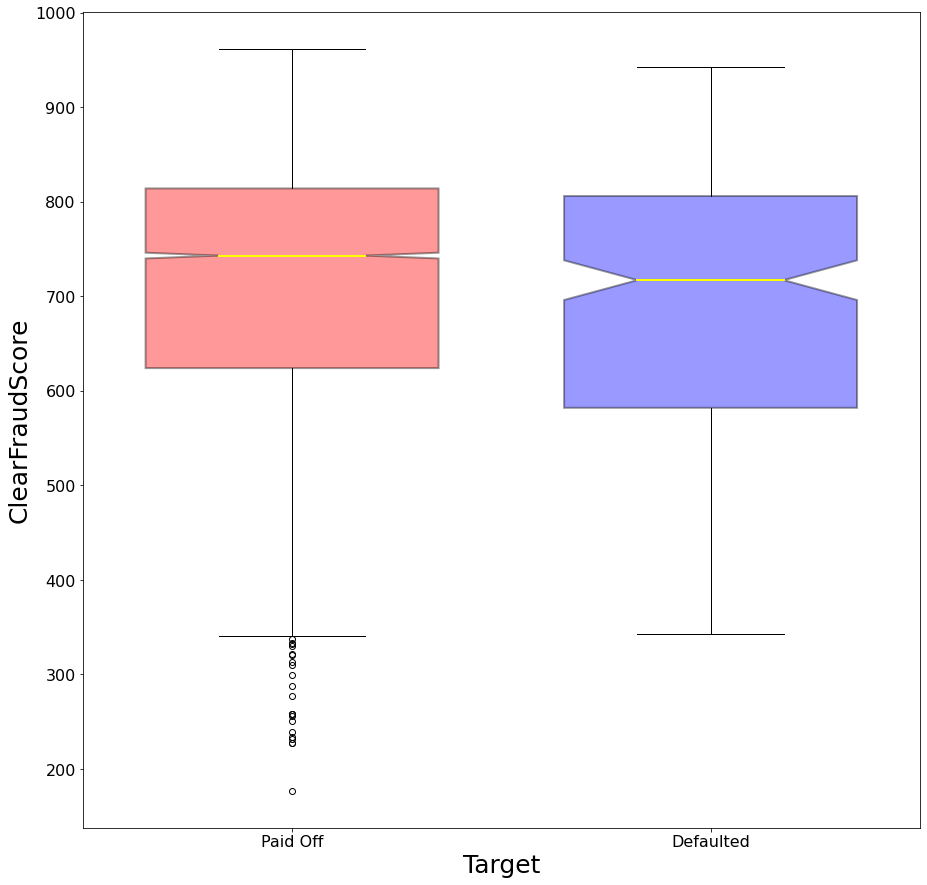

In [ ]:
paid_off = df[df['target']==1.0]['clearfraudscore']
defaulted = df[df['target']==0.0]['clearfraudscore']

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111)
boxplots = ax.boxplot([paid_off,defaulted],
           notch = True,
           labels=['Paid Off', 'Defaulted'],
           widths = .7,
           patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
          );

boxplot1 = boxplots['boxes'][0]
boxplot1.set_facecolor('red')

plt.xlabel('Target', fontsize = 25);
plt.ylabel('ClearFraudScore', fontsize = 25);
plt.xticks(fontsize = 16);
plt.yticks(fontsize = 16);

Here I am plotting the distribution of values for *clearfraudscore* vs the target values of *paid off* and *defaulted* and *paid off* has outliers in the range of 180-445. My understanding of this is that *clearfraudscore* seems to be some sort of score for the likelihood of a fraud happening. The range of values for both cases is somewhat similar but those that are paid off tend to have more outliers with a lower clear fraud score. I think that the clearfraudscore is derived from a company Clarity Services that has a service called Clarity Fraud as per [this link](https://www.businesswire.com/news/home/20170516006021/en/Clarity-Services-Introduces-Clear-Fraud-for-Online-Installment). 

## Binning clearFraudScore into Categories

Maybe *clearFraudScore* can be separated into groups instead of being a continous value. I will bin the values that exist in the entire range of the *clearFraudScore* into individual bins where each bin is of the size *250* which results in 4 different groups. 


In [ ]:
df['clearFraudScoreGroup'] = pd.cut(df['clearfraudscore'], bins=[0, 250, 500, 750,1000, float('Inf')], labels=['cfs0', 'cfs1', 'cfs2', 'cfs3', 'cfs4'])

In [ ]:
df.head(10)

,index,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,loanStatus,loanAmount,originallyScheduledPaymentAmount,state,leadType,leadCost,fpStatus,clarityFraudId,hasCF,target,isCollection,total_amount_paid,remainder_to_pay,days_to_process_loan,.underwritingdataclarity.clearfraud.clearfraudinquiry.thirtydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.twentyfourhoursago,.underwritingdataclarity.clearfraud.clearfraudinquiry.oneminuteago,.underwritingdataclarity.clearfraud.clearfraudinquiry.onehourago,.underwritingdataclarity.clearfraud.clearfraudinquiry.ninetydaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.sevendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.tenminutesago,.underwritingdataclarity.clearfraud.clearfraudinquiry.fifteendaysago,.underwritingdataclarity.clearfraud.clearfraudinquiry.threesixtyfivedaysago,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryonfilecurrentaddressconflict,.underwritingdataclarity.clearfraud.clearfraudindicator.totalnumberoffraudindicators,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithaddress,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryageyoungerthanssnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.ssnreportedmorefrequentlyforanother,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbytradeopenlt90days,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssninvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresscautious,.underwritingdataclarity.clearfraud.clearfraudindicator.morethan3inquiriesinthelast30days,.underwritingdataclarity.clearfraud.clearfraudindicator.onfileaddressnonresidential,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedpriortossnissuedate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseformatinvalid,.underwritingdataclarity.clearfraud.clearfraudindicator.inputssnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.inquiryaddresshighrisk,.underwritingdataclarity.clearfraud.clearfraudindicator.inquirycurrentaddressnotonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnissuedatecannotbeverified,.underwritingdataclarity.clearfraud.clearfraudindicator.highprobabilityssnbelongstoanother,.underwritingdataclarity.clearfraud.clearfraudindicator.maxnumberofssnswithanybankaccount,.underwritingdataclarity.clearfraud.clearfraudindicator.bestonfilessnrecordedasdeceased,.underwritingdataclarity.clearfraud.clearfraudindicator.currentaddressreportedbynewtradeonly,.underwritingdataclarity.clearfraud.clearfraudindicator.creditestablishedbeforeage18,.underwritingdataclarity.clearfraud.clearfraudindicator.telephonenumberinconsistentwithstate,.underwritingdataclarity.clearfraud.clearfraudindicator.driverlicenseinconsistentwithonfile,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedascellphone,.underwritingdataclarity.clearfraud.clearfraudindicator.workphonepreviouslylistedashomephone,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamematch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressmatch,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchtype,.underwritingdataclarity.clearfraud.clearfraudidentityverification.ssnnamereasoncodedescription,.underwritingdataclarity.clearfraud.clearfraudidentityverification.phonematchresult,.underwritingdataclarity.clearfraud.clearfraudidentityverification.nameaddressreasoncodedescription,.underwriting

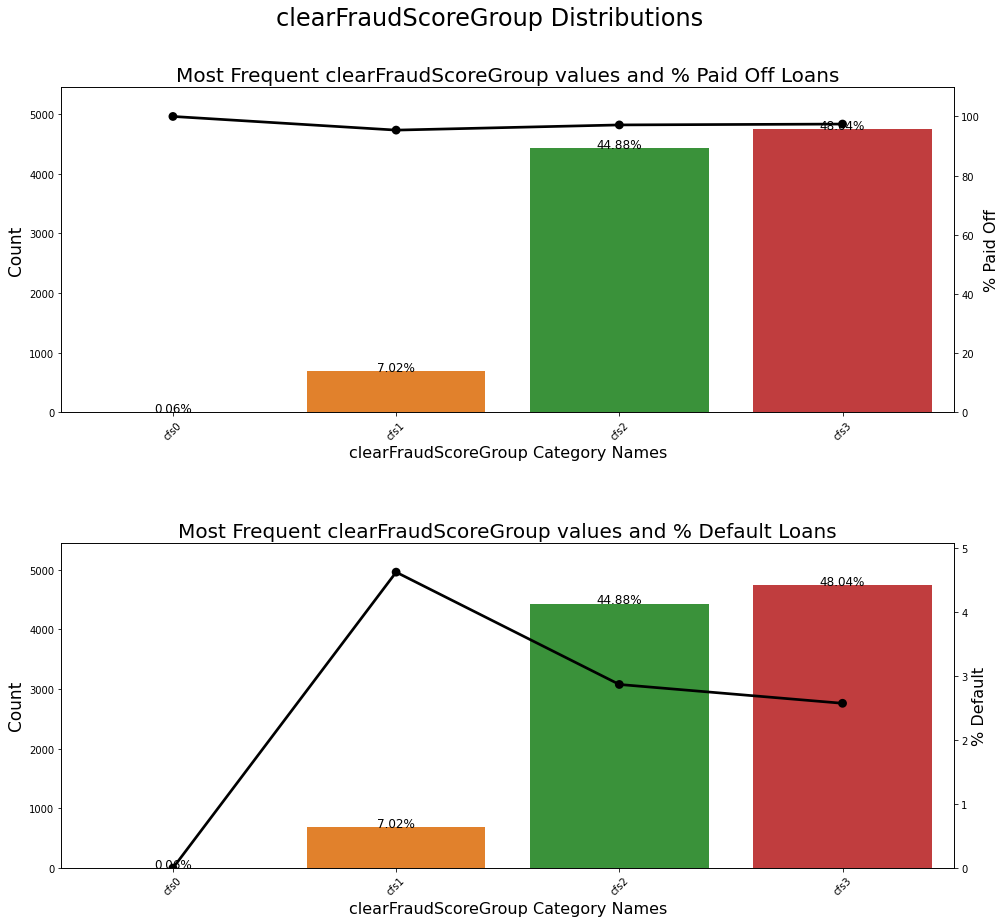

In [ ]:
plot_target_vs_col(df, 'clearFraudScoreGroup')

Assuming that *clearfraudscore* indicates the level

